In [1]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-10-04 11:24


In [2]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [75]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        #p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] = (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [4]:
def random_orthogonal(n):
    a = np.random.random((n,n))
    q, r = np.linalg.qr(a)
    
    return q

In [5]:
N = 10000
# so Plate technically doesn't require unit vectors
plate_vectors = np.random.randn(len(random_idx.alphabet), N) / N ** 0.5


In [6]:
def cconv(a, b):
    return real(ifft(fft(a) * fft(b)))
    
def ccinv(a):
    return real(ifft(np.conj(fft(a))))

In [7]:
def test_capacity_kanerva_ro(N, ro, D=27, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    # we have ro, but lets also store read out matrices
    last_input = np.linalg.matrix_power(ro, -1)
    input_K = np.linalg.matrix_power(ro, -K)
    first_input = np.linalg.matrix_power(ro, -1) # this one we will build up continuously

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(len(letter_sequence))
    lidx_input_K = np.zeros(len(letter_sequence))
    lidx_first_input = np.zeros(len(letter_sequence))

    for i,l in enumerate(letter_sequence[1:]):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(last_input, hypercapacity)
        v_input_K = np.dot(input_K, hypercapacity) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(first_input, hypercapacity)
        first_input = np.dot(last_input, first_input) # we have to continually update this readout matrix

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

        lli = random_idx.alphabet[int(lidx_last_input[i])]
        liK = random_idx.alphabet[int(lidx_input_K[i])]
        lfi = random_idx.alphabet[int(lidx_first_input[i])]

        #print '%03d:' % i, l, lli, liK, lfi

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [8]:
def test_capacity_plate_ro(N, ro, D=27, K=5, trials=5e3):
    letter_vectors = 1/N * np.random.randn(D, N)

    hypercapacity = np.zeros(N)

    # we have ro, but lets also store read out matrices
    last_input = np.linalg.matrix_power(ro, -1)
    input_K = np.linalg.matrix_power(ro, -K)
    first_input = np.linalg.matrix_power(ro, -1) # this one we will build up continuously

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(len(letter_sequence))
    lidx_input_K = np.zeros(len(letter_sequence))
    lidx_first_input = np.zeros(len(letter_sequence))

    for i,l in enumerate(letter_sequence[1:]):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(last_input, hypercapacity)
        v_input_K = np.dot(input_K, hypercapacity) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(first_input, hypercapacity)
        first_input = np.dot(last_input, first_input) # we have to continually update this readout matrix

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

        lli = random_idx.alphabet[int(lidx_last_input[i])]
        liK = random_idx.alphabet[int(lidx_input_K[i])]
        lfi = random_idx.alphabet[int(lidx_first_input[i])]

        #print '%03d:' % i, l, lli, liK, lfi

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [9]:
def test_capacity_kanerva_roll(N, D, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [68]:
#test_N = [100, 200, 500]
#test_N = [100, 500, 1000, 5000, 10000]

test_N = [1000, 2000, 4000, 8000, 16000]
runs = 15

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_kanerva_roll(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-kanerva_roll-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0
Duration:  0.592795133591
Duration:  0.868319988251
Duration:  1.46145510674
Duration:  2.76451301575
Duration:  5.36792588234
1
Duration:  0.48441696167
Duration:  0.811909914017
Duration:  1.45917701721
Duration:  2.74995303154
Duration:  5.36767411232
2
Duration:  0.484073877335
Duration:  0.812096834183
Duration:  1.4561290741
Duration:  2.75527906418
Duration:  5.38552618027
3
Duration:  0.486413002014
Duration:  0.813322067261
Duration:  1.45877480507
Duration:  2.75678706169
Duration:  5.39311099052
4
Duration:  0.483412981033
Duration:  0.811743974686
Duration:  1.45844507217
Duration:  2.77167582512
Duration:  5.40849113464
5
Duration:  0.485059976578
Duration:  0.811355113983
Duration:  1.46313810349
Duration:  2.75428199768
Duration:  5.42371201515
6
Duration:  0.495343923569
Duration:  0.81346988678
Duration:  1.46028399467
Duration:  2.75956106186
Duration:  5.42691588402
7
Duration:  0.48826789856
Duration:  0.814196109772
Duration:  1.46246004105
Duration:  2.756762981

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [170]:
h = np.load('data/hypervector_capacity-kanerva_roll-N=5-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
test_N = h['test_N']
run_id = h['run_id']
run_N = h['run_N']
K = 5
runs = len(unique(run_id))

In [171]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


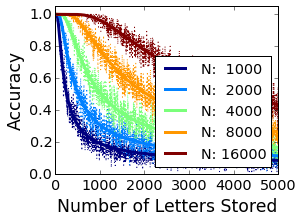

In [174]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN),lw=3, label="N: %5i" % test_N[idxN])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Letters Stored');
ylabel('Accuracy')
ylim([0, 1.05])


savefig('figures/letter_capacity-kanerva_roll-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-kanerva_roll-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [12]:
#test_N = [100, 200, 500]
#test_N = [100, 500, 1000, 5000, 10000]

N = 4000
test_D = [2, 8, 32, 128, 512, 2048]
runs = 15

run_id = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for D in test_D:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_kanerva_roll(N, D)
        
        run_id.append(r)
        run_D.append(D)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-kanerva_roll-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_D=run_D, runs=runs, test_D=test_D)

0
Duration:  0.576737165451
Duration:  0.839200019836
Duration:  1.68199515343
Duration:  5.8730738163
Duration:  27.7756619453
Duration:  115.071057081
1
Duration:  0.463912010193
Duration:  0.728638887405
Duration:  1.67201209068
Duration:  5.75266599655
Duration:  26.4403917789
Duration:  121.063973188
2
Duration:  0.47247004509
Duration:  0.761906862259
Duration:  1.78201389313
Duration:  5.65413093567
Duration:  26.7751588821
Duration:  113.591192961
3
Duration:  0.460782051086
Duration:  0.713564872742
Duration:  1.66026496887
Duration:  5.44850111008
Duration:  25.6721189022
Duration:  119.298978806
4
Duration:  0.458307027817
Duration:  0.713814020157
Duration:  1.65645885468
Duration:  5.44767308235
Duration:  25.8004119396
Duration:  116.954945087
5
Duration:  0.496793985367
Duration:  0.737870931625
Duration:  1.66311407089
Duration:  5.51112413406
Duration:  26.1018748283
Duration:  116.664622068
6
Duration:  0.461777925491
Duration:  0.769243955612
Duration:  1.82529783249

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [175]:
h = np.load('data/hypervector_capacity-kanerva_roll-D=6-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
test_D = h['test_D']
run_id = h['run_id']
run_D = h['run_D']
N=4000
runs = len(unique(run_id))

In [176]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
    
li_mean = li_mean / runs


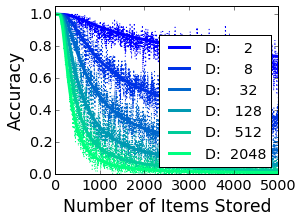

In [177]:
figure(figsize=(4,3))
cm=get_cmap('winter', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxD,D in enumerate(test_D):
    p_correct = p_correct_l(M, N=N, D=D)
    plot(M, p_correct, color=cm(idxD),lw=3, label="D: %5i" % test_D[idxD])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Items Stored');
ylabel('Accuracy')
ylim([0, 1.05])

savefig('figures/letter_capacity-kanerva_roll-D-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-kanerva_roll-D-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [10]:
def test_capacity_plate_cconv(N, D, K=5, trials=5e3):
    letter_vectors = np.random.randn(D, N) / N ** 0.5
    
    # This is the easy way, but don't know how else to get an appropriate cconv vector that
    # is all real and doesn't explode.
    rv = np.zeros(N)
    rv[1] = 1
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [11]:
def test_capacity_plate_roll(N, D, K=5, trials=5e3):
    letter_vectors = np.random.randn(D, N) / N ** 0.5

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [26]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b):
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
    
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
    
def fhrr_roll(a, r=1):
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

In [31]:
N = 10000

a = fhrr_vec(1, N)
b = fhrr_vec(1, N)
c = fhrr_bind(a, b)

binv = fhrr_inv(b)
a2 = fhrr_bind(binv, c)

d = fhrr_roll(c)
ainv = fhrr_inv(a)
e = fhrr_roll(d, -1) 
b2 = fhrr_bind(ainv, e)

print "a . a: ", np.dot(a, a.T)
print "a . a*:", np.dot(a, fhrr_inv(a).T)
print "a . b: ", np.dot(a, b.T)
print "a . c: ", np.dot(a, c.T)
print "a . ainv: ", np.dot(a, ainv.T)
print "c . d: ", np.dot(c, d.T)
print "b . b2: ", np.dot(b, b2.T)
print "a . a2: ", np.dot(a, a2.T)

a . a:  [[ 5000.]]
a . a*: [[-1.6066242]]
a . b:  [[-12.85049488]]
a . c:  [[-46.01265686]]
a . ainv:  [[-1.6066242]]
c . d:  [[ 99.00290228]]
b . b2:  [[ 5000.]]
a . a2:  [[ 5000.]]


In [30]:
hp = 0 * fhrr_vec(1, N)
print hp.shape

(1, 10000)


In [17]:
def test_capacity_fhrr(N, D, K=5, trials=5e3):
    letter_vectors = fhrr_vec(D, N)

    bind_vec = fhrr_vec(1, N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    
    hypercapacity = fhrr_bind(bind_vec, letter_vectors[lidx[0]:(lidx[0]+1), :])

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        lidx[i+1] = np.random.randint(D)
        
        lv = letter_vectors[lidx[i+1]:(lidx[i+1]+1), :]
        
        bind_vec = fhrr_roll(bind_vec)
        hypercapacity += fhrr_bind(bind_vec, lv)
        
        v_last_input = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -1)), hypercapacity)
        v_input_K = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -K)), hypercapacity)
        v_first_input = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -(i+1))), hypercapacity)
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [18]:
def test_capacity_fhrr_bind(N, D, K=5, trials=5e3):
    letter_vectors = fhrr_vec(D, N)

    bind_vec = fhrr_vec(1, N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    
    hypercapacity = fhrr_bind(bind_vec, letter_vectors[lidx[0]:(lidx[0]+1), :])

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        lidx[i+1] = np.random.randint(D)
        
        lv = letter_vectors[lidx[i+1]:(lidx[i+1]+1), :]
        
        #bind_vec = fhrr_roll(bind_vec)
        #hypercapacity += fhrr_bind(bind_vec, lv)
        hypercapacity = fhrr_bind(bind_vec, hypercapacity) + lv
        
        v_last_input = fhrr_bind(fhrr_inv(bind_vec), hypercapacity)
        #v_input_K = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -K)), hypercapacity)
        #v_first_input = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -(i+1))), hypercapacity)
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        #lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input#, lidx_input_K, lidx_first_input

In [63]:
#test_N = [100, 200, 500]
#test_N = [100, 500, 1000, 5000, 10000]

test_N = [1000, 2000, 4000, 8000, 16000]
runs = 15

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_fhrr(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-fhrr-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0
Duration:  1.24908208847
Duration:  1.77342605591
Duration:  2.82067704201
Duration:  3.79308700562
Duration:  5.3001639843
1
Duration:  1.08909201622
Duration:  1.34829878807
Duration:  1.83747410774
Duration:  2.82616090775
Duration:  4.86700606346
2
Duration:  1.1181230545
Duration:  1.36321592331
Duration:  1.85543704033
Duration:  2.87775588036
Duration:  4.96970582008
3
Duration:  1.17259693146
Duration:  1.5010778904
Duration:  2.07673192024
Duration:  3.060587883
Duration:  5.02411389351
4
Duration:  1.05885887146
Duration:  1.32824707031
Duration:  1.85220599174
Duration:  2.86834192276
Duration:  4.84991693497
5
Duration:  1.07742905617
Duration:  1.32126903534
Duration:  1.84078288078
Duration:  2.8119738102
Duration:  4.8787021637
6
Duration:  1.06772589684
Duration:  1.35675978661
Duration:  1.89276599884
Duration:  2.81862306595
Duration:  4.78572893143
7
Duration:  1.03318500519
Duration:  1.29026293755
Duration:  1.8067150116
Duration:  2.83822393417
Duration:  4.9188

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depr

In [30]:
h = np.load('data/hypervector_capacity-fhrr-N=5-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
test_N = h['test_N']
run_id = h['run_id']
run_N = h['run_N']
runs = len(unique(run_id))

In [31]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
    
li_mean = li_mean / runs


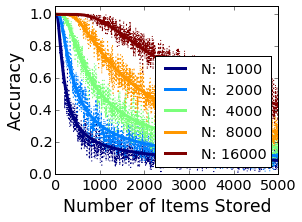

In [34]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN), lw=3, label="N: %5i" % test_N[idxN])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Items Stored');
ylabel('Accuracy')
ylim([0, 1.05])


savefig('figures/letter_capacity-fhrr_perm-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-fhrr_perm-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [54]:
#test_N = [100, 200, 500]
#test_N = [100, 500, 1000, 5000, 10000]

test_N = [1000, 2000, 4000, 8000, 16000]
runs = 15

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li = test_capacity_fhrr_bind(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        
filename = 'data/hypervector_capacity-fhrr_bind-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0
Duration:  0.367505073547
Duration:  0.389084100723
Duration:  0.507781028748
Duration:  0.767713069916
Duration:  1.31331706047
1
Duration:  0.317577123642
Duration:  0.400429010391
Duration:  0.505201101303
Duration:  0.781038045883
Duration:  1.31733798981
2
Duration:  0.316622018814
Duration:  0.416636943817
Duration:  0.537859916687
Duration:  0.803485870361
Duration:  1.30198907852
3
Duration:  0.357012987137
Duration:  0.446173906326
Duration:  0.589642047882
Duration:  0.816008090973
Duration:  1.29415011406
4
Duration:  0.320181131363
Duration:  0.420486927032
Duration:  0.550652980804
Duration:  0.764356136322
Duration:  1.28228592873
5
Duration:  0.324378013611
Duration:  0.381511926651
Duration:  0.49330997467
Duration:  0.823673009872
Duration:  1.37575793266
6
Duration:  0.359585046768
Duration:  0.44643497467
Duration:  0.573952913284
Duration:  0.839581012726
Duration:  1.38412189484
7
Duration:  0.362163066864
Duration:  0.44221997261
Duration:  0.570774078369
Durati

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depr

In [39]:
h = np.load('data/hypervector_capacity-fhrr_bind-N=5-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
test_N = h['test_N']
run_id = h['run_id']
run_N = h['run_N']
runs = len(unique(run_id))

In [40]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
    
li_mean = li_mean / runs


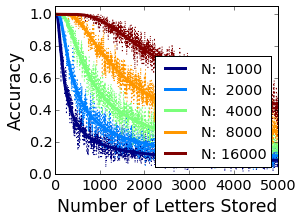

In [43]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN),lw=3, label="N: %5i" % test_N[idxN])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Letters Stored');
ylabel('Accuracy')
ylim([0, 1.05])

savefig('figures/letter_capacity-fhrr_bind-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-fhrr_bind-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [40]:
#test_N = [100, 200, 500]
test_N = [1000, 2000, 4000, 8000, 16000]
runs = 15

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_plate_roll(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-plate-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0
Duration:  0.367705106735
Duration:  0.442801952362
Duration:  0.749208211899
Duration:  1.24633193016
Duration:  2.03805303574
1
Duration:  0.336549043655
Duration:  0.507565021515
Duration:  0.960242033005
Duration:  1.53188991547
Duration:  2.70175218582
2
Duration:  0.343003988266
Duration:  0.470817089081
Duration:  0.718869924545
Duration:  1.16168498993
Duration:  2.22389292717
3
Duration:  0.358694076538
Duration:  0.446959018707
Duration:  0.714138031006
Duration:  1.18809294701
Duration:  2.18626999855
4
Duration:  0.359050989151
Duration:  0.471582174301
Duration:  0.729793071747
Duration:  1.21825313568
Duration:  2.18499994278
5
Duration:  0.345541954041
Duration:  0.458324193954
Duration:  0.714332103729
Duration:  1.17241120338
Duration:  2.15365695953
6
Duration:  0.338838100433
Duration:  0.466275930405
Duration:  0.745479106903
Duration:  1.17065000534
Duration:  2.06428098679
7
Duration:  0.331148862839
Duration:  0.451680183411
Duration:  0.709356069565
Duration: 

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [52]:
h = np.load('data/hypervector_capacity-plate-N=5-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
test_N = h['test_N']
run_id = h['run_id']
run_N = h['run_N']
runs = len(unique(run_id))

In [53]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


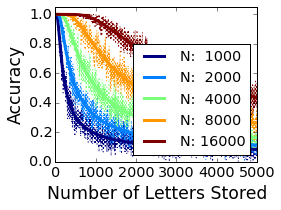

In [54]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN), lw=3, label="N: %5i" % test_N[idxN])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Letters Stored');
ylabel('Accuracy')
ylim([0, 1.05])
plt.tight_layout()

savefig('figures/letter_capacity-plate-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-plate-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [ ]:

uN = unique(run_N)

figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=3, label="N: %5i" % test_N[i])
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN),lw=3)

legend(loc='upper right');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

        

In [ ]:
def test_capacity_sparsity(N, D, K=5, null_prob=0.1, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D+1, N) > 0) - 1
    
    # The (D+1)th vector is the null vector
    letter_vectors[D, :] = 0
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D+1)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros((trials,2))
    lidx_input_K = np.zeros((trials,2))
    lidx_first_input = np.zeros((trials,2))

    for i in range(int(trials)-1):
        
        if np.random.rand() < null_prob:
            lidx[i+1] = D
        else:
            lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(letter_vectors, np.roll(hypercapacity, -1).T)
        v_input_K = np.dot(letter_vectors, np.roll(hypercapacity, -K).T) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(letter_vectors, np.roll(hypercapacity, -(i+1)).T)
        
        lidx_last_input[i,:] = [np.argmax(v_last_input), np.amax(v_last_input)]
        lidx_input_K[i,:] = [np.argmax(v_input_K), np.amax(v_input_K)]
        lidx_first_input[i,:] = [np.argmax(v_first_input), np.amax(v_first_input)]

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

## Random Orthogonal Matrix

In [ ]:
#test_N = [100, 200, 500]
test_N = [100, 500, 1000, 5000, 10000]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_natural_ro(N, random_orthogonal(N))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-natural_ro-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

In [45]:
h = np.load('data/hypervector_capacity-natural_ro-N=5-r=5-n160315.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
## HACK ##
runs = 5
test_N = [100, 500, 1000, 5000, 10000]

run_id = np.arange(len(lidx_all))
run_N = test_N * runs
##

In [46]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
K=5

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


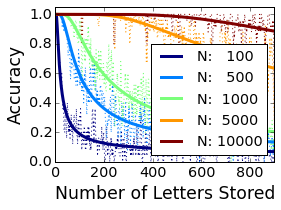

In [50]:
figure(figsize=(4,3))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=1)


M = np.arange(li_mean.shape[0])

for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN), lw=3, label="N: %5i" % test_N[idxN])


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of Letters Stored');
ylabel('Accuracy')
ylim([0, 1.05])
ax = gca()
ax.set_xticks(arange(0, 1000, 200))

plt.tight_layout()

savefig('figures/letter_capacity-random_unitary-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-random_unitary-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 4.1. Capacity of Hyper-RNN:** A string of 900 characters was sequentially stored in a hyper-rnn with random orthogonal weights. The readout of the most recent input falls off at different rates depending on the dimensionality. A 1000-D hyper-rnn can store over 50 memories of 27 characters without mistakes. Once the Hyper-RNN begins to fill up its information content per item diminishes until the item is recovered at near chance level. 

### 4.2 Capacity of Equivalent Hypervector

We will next create a hypervector that has the same properties as the linear RNN. We show that the capacity is the same, and that the statistics of the letters do not matter. This will enable us to much more thoroughly explore the capacity of such networks and the relationships to their dimensionality as well as the input's dimensionality (the computations are way faster, too). Further, we can use the hypervector algebra and the translation to RNNs to make conclusions about the information capacity of RNNs and other systems which store information using high-dimensional vectors.


In [ ]:
def test_capacity_independent_roll(N, D, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [ ]:
test_N = [100, 500, 1000, 5000, 10000]
#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []
K = 5

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, len(random_idx.alphabet), K=K)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-independent_roll-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N, K=K)


In [ ]:
h = np.load('data/hypervector_capacity-independent_roll-N=5-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']
#K = h['K']

In [ ]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
uN = np.array([100, 500, 1000, 5000, 10000])

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


In [ ]:

uN = unique(run_N)

figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=3, label="N: %5i" % test_N[i])
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN),lw=3)

legend(loc='upper right');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

        

In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0, 900])

** Figure 4.2. The Capacity of the Equivalent Hypervector to the RNN.**

The capacities are the same, and this should be expected due to the efforts we went through connecting the algebra to the weight matrix. However, the algebra is *way* faster to simulate so we can explore the capacity more thoroughly by just relying on the faster `np.roll` operation instead of a matrix multiply. So we can see what happens as we add many more items.

In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.3. Readout of Kth most recent input versus items stored:** Utilizing the more efficient hypervector operations allows us to explore the capacity much faster and for much larger N.

We can look back into the recurrent neural network a fixed number of steps and get a very similar curve. This curve is realted to the first curve typically, because if the network makes a mistake after only 1 step, it is likely to make the same mistake after K steps. In this case K is pretty small, so the curves look very similar, and they will have noise correlations.


In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', fi_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of first input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

** Figure 4.4. Readout of First Input:** The curves are box/clunky because the answer is always the same letter.

We also kept track of a matrix to read out the very initial input into the neural network and this has similar decay properties. This is more jagged becaues the first input is always the same letter, and so the network is right or wrong for extended periods of time by chance, since each check is correlated.



### 4.3 Capacity with Large N

Now we can explore much higher-dimensional hypervectors, because we do not have to suffer through the computations of thousands of 1000x1000 matrix multiplies. Next, we will vary N proportionally, and see that the capacity decay is smoothly related to the size of N.

In [ ]:
test_N = [1000, 3000, 9000, 27000, 81000]
test_D = [32]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

K=5

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, D, K=K)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-proportional_N-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D, K=K)


In [ ]:
h = np.load('data/hypervector_capacity-proportional_N-N=5-D=1-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']
#K = h['K']

In [ ]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.5. Memory decay varies smoothly with proportional N:** We created the capacity curve for hypervectors with different dimensionalities. By increasing N proportionally (3x) in each curve, we can see a clear pattern in the relationship with capacity and dimensionality.

Becoming more clear that there is a direct relationship with these curves and the particular value of N used.

In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.6. Memory decay varies smoothly with proportional N:** We see pretty much the same capacity curve when we measure the element that was stored $K=5$ timesteps ago.

### 4.4 Capacity and dimensionality of tokens

Another factor that affects the capacity of the hypervector is the dimensionality of the tokens. In the above examples, we have been storing the fixed tokens of 'abcd...xyz\_'. The hypervector or rnn would receive one of these 27 possibilities at each time point, which we will now vary and we will call the number of possible tokens $D$. 

We can change $D$ by adding more letter tokens. e.g. we could include all lower and upper case letters and have 53 tokens, we could include all punctuation and have even more. 

We can also note a potential relationship between sparsity of the input and $D$. Note that the input is always 1-sparse of $D$, so the input structure is 1-sparse and has a dimensionality of $D$.  We could imagine a different kind of input stream into an RNN, where the input is 2-sparse: i.e. you get two letters simultaneously. However, this can be translated into a 1-sparse representation with $D^2$ number of tokens. This could be used to fundamentally connect an input stream's dimensionality with its sparsity.


In [ ]:
test_N = [1000]
test_D = [2, 8, 32, 128, 512, 2048, 8192]
#test_D = [2, 8, 32, 128]


#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

K=5

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, D, K=K, trials=5e4)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-proportional_N-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D, K=K)


In [ ]:
h = np.load('data/hypervector_capacity-proportional_N-N=1-D=7-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']

#K = h['K']

In [ ]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


In [ ]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_all = np.zeros((lidx_li_all[0].shape[0], len(uD), runs))
iK_all = np.zeros((lidx_iK_all[0].shape[0], len(uD), runs))
fi_all = np.zeros((lidx_fi_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        li_all[:,iD,ii] = np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_all[:,iD,ii] = np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_all[:,iD,ii] = np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')

li_mean = np.mean(li_all, axis=2)    
iK_mean = np.mean(iK_all, axis=2)    
fi_mean = np.mean(fi_all, axis=2)    

In [ ]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])
         
for i in range(iK_mean.shape[1]):
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="D: %5i" % test_D[i])

legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0,500])

**Figure 4.7. Varying the dimensionality of the tokens with fixed N:** More items can be stored if the number of possible items is smaller. 

Smoothly varying the dimensionality of the tokens (e.g. letters is $D=27$) increase the rate of fall-off.

Having more tokens means that the network stores more bits per token. If we normalize these curves based on the number of bits each token itself contains, then we see another very important relationship.

In [ ]:
figure(figsize=(8,6))

cm=get_cmap('jet', iK_mean.shape[1])

for j in range(iK_all.shape[2])[::-1]:
    for i in range(iK_all.shape[1]):
        #plot(li_mean[:,i], color=cm(i))
        smoothN = 5
        pp = np.convolve(iK_all[:,i,j], np.ones(smoothN)/smoothN, mode='same')
        plot(np.log2(test_D[i] * pp) * pp, ':',
             color=cm(i), lw=1)
        
smoothN=5
for i in range(iK_mean.shape[1])[::-1]:
    #plot(li_mean[:,i], color=cm(i))
    pp = np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')
    plot(np.log2(test_D[i] * pp) * pp,
         color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='upper right');
title('Readout Bits of Kth most recent input', fontsize=20);
xlabel('Number of Items stored', fontsize=16);
ylabel('Readout Bits', fontsize=16)
xlim([0,1000])

**Figure 4.8. Decay of memory in bits is consistent regardless of bits per token:** The fraction correct curves were translated to bits based on the number of possible tokens (e.g. getting a token correct when there is two possible tokens gives 1 bit, when a correct token out of eight gives 3 bits). 

This curve points to a maximum level of bits that can be stored in the hypervector. Integral of this curve will approach the maximum. 

These curves at least seem to be similar, it may be possible that they are not. It makes some sense that the time-constants of these curves would decrease as D gets large.


### 4.5 Total number of bits capable of being stored in the hypervector

To best estimated the total capacity of the data in the hypervector, we will attempt to read out as much information as possible from the hypervector as we fill it up. We will compare how many total bits can be read versus how many bits that are added to the memory.


In [161]:
# with this function, we are going to try and readout everything in the hypervector each time we add something
def test_capacity_D_totalbits(N, D, bit_factor=20, trials=5e2):
    
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    hypercapacity = np.zeros(N)

    tstart = time.time()
    
    bit_ratio = floor(bit_factor / np.log2(D))
    
    lidx = np.zeros(trials * bit_ratio)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    totalbits = np.zeros(trials)

    for i in range(int(trials * bit_ratio)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        if mod(i+1, bit_ratio) == 0:
            iscorrect = np.zeros(i+1)
            for j in range(i+1):
                v_total = np.roll(hypercapacity, -(i-j))
                iscorrect[j] = float(lidx[j+1] == argmax(np.dot(letter_vectors, v_total.T)))
            
            t = i // bit_ratio
            #totalbits[t] = (1.0/(1-1.0/D)) * len(iscorrect) * np.log2(D) * (np.mean(iscorrect) - 1.0/D)            
            totalbits[t] = len(iscorrect) * np.mean(iscorrect) * log2(np.mean(iscorrect) * D)
            #print np.mean(iscorrect),
            #totalbits[i] = len(iscorrect) * np.log2(D) * (mean(iscorrect))
            
            
    print 'Duration: ', time.time() - tstart
    
    return lidx, totalbits

In [162]:
test_N = [10000]
#test_D = [2, 4, 128]
test_D = [2, 4, 8, 2**5, 2**7, 2**10, 2**15]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 3#5

run_id = []
run_N = []
run_D = []
lidx_all = []
totalbits_all = []
bit_factor=20 # this makes it calculate the storage every 20 bits we add
for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, totalbits = test_capacity_D_totalbits(N, D, bit_factor=bit_factor, trials=2000)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            totalbits_all.append(totalbits)

filename = 'data/hypervector_capacity-totalbits-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, totalbits_all=totalbits_all, bit_factor=bit_factor,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D)


0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [155]:
h = np.load('data/hypervector_capacity-totalbits-N=1-D=5-r=5-n160426.npz')
lidx_all = h['lidx_all']
totalbits_all = h['totalbits_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
bit_factor = h['bit_factor']

In [156]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

tb_all = np.zeros((totalbits_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        tb_all[:,iD,ii] = np.array(totalbits_all[i])
        
tb_mean = np.mean(tb_all, axis=2)

(0, 10000)

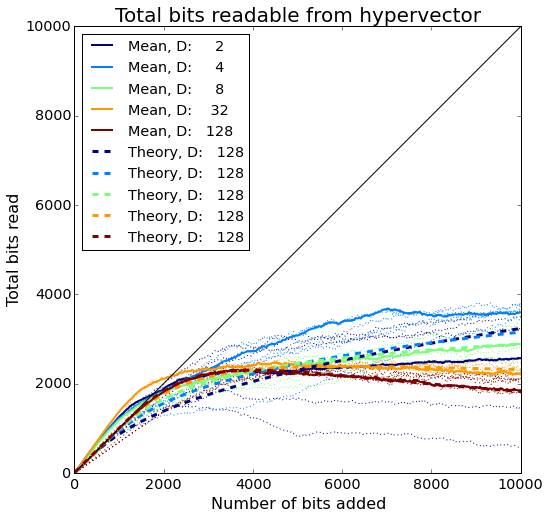

In [160]:
figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        bit_ratio = bit_factor // np.log2(test_D[j])
        plot(np.log2(test_D[j]) * bit_ratio *(arange(tb_all.shape[0]) + 1) + 1, 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    bit_ratio = bit_factor // np.log2(test_D[j])

    plot(np.log2(test_D[j]) * bit_ratio * (arange(tb_mean.shape[0]) + 1) + 1,
        tb_mean[:,i], color=cm(i), lw=2, label="Mean, D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
uD = unique(run_D)
uN = unique(run_N)

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD), '--',
             color=cm(idxD), lw=3, label="Theory, D: %5i" % test_D[i])  
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim(np.array(plot_range))
ylim(np.array(plot_range))


(0, 4000)

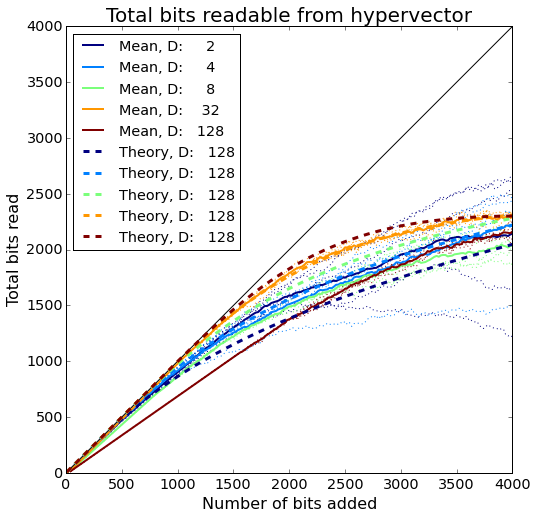

In [158]:
figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        plot(bit_factor * (arange(tb_all.shape[0]) + 1), 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    plot(bit_factor * (arange(tb_mean.shape[0])+1),
        tb_mean[:,i], color=cm(i), lw=2, label="Mean, D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
uD = unique(run_D)
uN = unique(run_N)

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD), '--',
             color=cm(idxD), lw=3, label="Theory, D: %5i" % test_D[i])  
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim([0, 4000])
ylim([0, 4000])


In [159]:
test_N

array([5000])

In [ ]:
tb_mean[2,-1]

**Figure 4.9. The cumulative total information stored in the hypervector:** We read out all the information (i.e. the entire history of the sequence) as we added more and more elements and plotted the bits that were read out versus the bits that were added. The black line indicates an equivalent amount of bits read and added. The hypervectors initially store all of the infomration reliably, but this falls off to a saturation level as the capacity is approached. (Noise can make this measurement drift and the variance of the bits read increases due to this noise as more bits are added.) 

The capacity is based on the total number of bits that are added to the hypervector. When there are more potential tokens, less tokens can be stored, but there are more bits per token and these effectively cancel out. 


In [ ]:
import scipy

test_D = [20]
test_N = [2000]

M = np.arange(0, 5000)

for idxN,N in enumerate(test_N):
    for idxD,D in enumerate(test_D):
        p_correct = (1 - scipy.special.erf(-(N/(2*M-1))**0.5))**(M*(D-1))
        p_correct[p_correct>1] = 1
        plot(M, p_correct)
        

        

In [ ]:
uD  = [2,4,8,16,32,64,128]
uN = [1000]
bit_factor=20
plot_range = [0,max(uN)]
plot(plot_range, plot_range, 'k')


cm=get_cmap('jet', len(uD))

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, 5*bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD),
             color=cm(idxD), lw=1)
        
ylim([0, 4000])
xlim([0, 20000])

In [ ]:
M = np.logspace(1, 9, 100)
Ds = [2, 8, 32, 128]

for D in Ds:
    pp = p_correct_l(M, N=1000, D=D)
    plot(M, pp * log2(pp*D))
    
xscale('log')

In [ ]:
M

In [ ]:
import scipy

h = np.load('data/hypervector_capacity-proportional_N-N=1-D=7-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
K = h['K']
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs

figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])
smoothN = 5

for i in range(iK_mean.shape[1]):
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':',
         color=cm(i), lw=3, label="D: %5i" % test_D[i])

legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

M = np.arange(1, iK_mean.shape[0], 10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    for idxD,D in enumerate(test_D):
        p_correct = p_correct_l(M, N=N, D=D)
        plot(M, p_correct, color=cm(idxD),lw=3)

legend(loc='upper right');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

xlim([0,2000])

In [ ]:
test_N = [100 * 2**(N) for N in range(12)]
test_D = [2**(D+1) for D in range(16)]

cm=get_cmap('jet', len(test_D))

p_correct = np.zeros((len(test_N), len(test_D), max(test_N)))
for iN,N in enumerate(test_N):
    print N,
    for iD,D in enumerate(test_D):
        p_correct[iN, iD, :N] = p_correct_l(arange(N)+1, N=N, D=D)
        
filename = 'data/p_correct-theory-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, p_correct=p_correct, test_N=test_N, test_D=test_D)


In [ ]:
filename = 'data/p_correct-theory-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, p_correct=p_correct, test_N=test_N, test_D=test_D)


In [64]:
h = np.load('data/p_correct-theory-N=12-D=16-n160503.npz')
p_correct = h['p_correct']
test_N = h['test_N']
test_D = h['test_D']

p_tol=0.99999: N = M * ( 3.88 log2(D) + 36.20 )
p_tol=0.99990: N = M * ( 3.70 log2(D) + 27.63 )
p_tol=0.99900: N = M * ( 3.38 log2(D) + 19.74 )
p_tol=0.99000: N = M * ( 3.18 log2(D) + 11.11 )
p_tol=0.90000: N = M * ( 2.62 log2(D) + 3.25 )
p_tol=0.80000: N = M * ( 2.34 log2(D) + 1.04 )


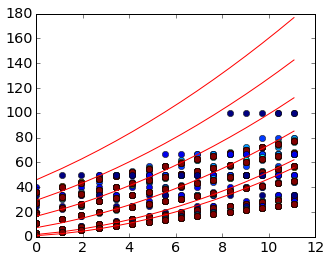

In [65]:
import scipy
from scipy import stats

test_p_tol = [1-1e-5, 1-1e-4, 1-1e-3, 1-1e-2, 1-1e-1, 1-2e-1]

figure(figsize=(5,4))

cm = get_cmap('jet', len(test_N))

p_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.zeros((len(test_N), len(test_p_tol)))
intD = np.zeros((len(test_N), len(test_p_tol)))

for ip, p_tol in enumerate(test_p_tol[0:]):
    for iN,N in enumerate(test_N):
        for iD,D in enumerate(test_D):
            p_tol_M[iN, iD, ip] = np.nonzero(np.squeeze(p_correct[iN, iD, :]) < p_tol)[0][0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / p_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N)
        #plot(xD, slD[iN, ip] * xD + intD[iN, ip], color=cm(iN))
        
    #plot(xD, np.mean(slD[:,ip]) *xD + np.mean(intD[:,ip]), 'k', lw=3)
    C = -np.log(1-p_tol)
    gamma = 1.7
    plot(xD, gamma**-2 * (xD + C) ** 2, 'r')
    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, mean(slD[:,ip]), mean(intD[:,ip]))
    
    

In [ ]:
test_N

In [ ]:
idx = 5

print -np.log(1-test_p_tol[idx])/gamma**2, (-np.log(1-test_p_tol[idx]))**2/gamma**2

In [ ]:
test_D

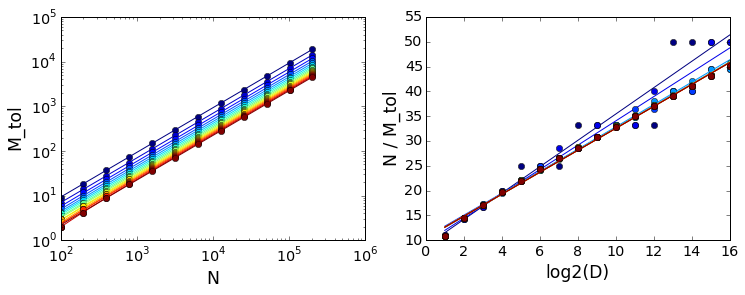

In [66]:
from scipy import stats

plt.rc('text', usetex=False)

figure(figsize=(12,4))
slN = np.zeros(len(test_D))
intN = np.zeros(len(test_D))
rN = np.zeros(len(test_D))
pN = np.zeros(len(test_D))
errN = np.zeros(len(test_D))

cm = get_cmap('jet', len(test_D))

ip=3

subplot(121)
for iD, D in enumerate(test_D):
    xN = np.array(test_N)
    yN = p_tol_M[:, iD, ip]
    slN[iD], intN[iD], rN[iD], pN[iD], errN[iD] = stats.linregress(xN, yN)
    
    plot(xN, yN, 'o', color=cm(iD), label="D=%2d" % D)
    plot(xN, xN * slN[iD]  + intN[iD], color=cm(iD))
#legend(loc='upper left')

xlabel(r'N')
ylabel(r'M_tol')
xscale('log')
yscale('log')
slD = np.zeros(len(test_N))
intD = np.zeros(len(test_N))
cm = get_cmap('jet', len(test_N))

subplot(122)
for iN, N in enumerate(test_N[:]):
    xD = np.log2(np.array(test_D))
    yD = N / p_tol_M[iN, :, ip]
    slD[iN], intD[iN], r, p, err = stats.linregress(xD, yD)
    plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N)
    plot(xD, slD[iN] * xD + intD[iN], color=cm(iN))
    
#legend(loc='upper right')
xlabel('log2(D)')
ylabel('N / M_tol')
#axis('tight')



In [ ]:
yN

In [ ]:
slN

In [ ]:
print 1/np.nanmean(slN)
print np.nanmean(intN)
print np.nanmean(slD)
print np.nanmean(intD)

In [ ]:
h = np.load('data/hypervector_capacity-totalbits-N=1-D=3-r=5-n160420.npz')
lidx_all = h['lidx_all']
totalbits_all = h['totalbits_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
run_id = np.array(run_id)
run_D = np.array(run_D)

bit_factor = 20

uD = unique(run_D)
uN = unique(run_N)

tb_all = np.zeros((totalbits_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        tb_all[:,iD,ii] = np.array(totalbits_all[i])
        
tb_mean = np.mean(tb_all, axis=2)


figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        plot(bit_factor * (arange(tb_all.shape[0]) + 1), 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    plot(bit_factor * (arange(tb_mean.shape[0])+1),
        tb_mean[:,i], color=cm(i), lw=3, label="D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
 
for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.arange(1, 2*bit_ratio * tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        plot(np.log2(iD) * (M), 
             M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             color=cm(idxD), lw=1)
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim([0, 10000])
ylim(plot_range)


In [ ]:
plot(plot_range, plot_range, 'k')

uD  = [2,4,8,16,32,64,128]
cm=get_cmap('jet', len(uD))

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, 5*bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        plot(np.log2(iD) * (M), 
             M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             color=cm(idxD), lw=1)
        
ylim([0, 4000])


In [ ]:
N=2000
M=[2, 200, 2000]

M = np.array(M)

avals = np.linspace(N - 5 * (N*np.max(M))**0.5, N+5*(N*np.max(M))**0.5, 10000)
p = np.zeros((len(avals)-1, len(M)))
for ia,a in enumerate(avals[1:]):
    p[ia, :] = ncdf(float(avals[ia+1]-N)/((M-1)*N)**0.5) - ncdf(float(avals[ia]-N)/((M-1)*N)**0.5)
    
plot(avals[1:], p)

In [ ]:
len(M)

### Capacity with null values


In [121]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    pp = np.zeros(len(M))
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        p[:, iM] = (ncdf((avals[1:]) / ((Mval)*N)**0.5) - ncdf((avals[:-1]) / ((Mval)*N)**0.5))
        #p[:, iM] = (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D)
        
        pp[iM] = ncdf(N*reject_thresh/(Mval*N)**0.5) ** D

    return pp #np.sum(p, axis=0)**D

In [135]:
def test_capacity_null(N, D, K=5, trials=5e3, p_null=0.2):
    letter_vectors = 2 * (np.random.randn(D+1, N) > 0) - 1
    
    # The (D+1)th vector is the null vector
    letter_vectors[D, :] = 0
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D+1)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros((trials,2))
    lidx_input_K = np.zeros((trials,2))
    lidx_first_input = np.zeros((trials,2))

    for i in range(int(trials)-1):
        
        if np.random.rand(1) < p_null:
            lidx[i+1] = D
        else:
            lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(letter_vectors, np.roll(hypercapacity, -1).T)
        v_input_K = np.dot(letter_vectors, np.roll(hypercapacity, -K).T) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(letter_vectors, np.roll(hypercapacity, -(i+1)).T)
        
        lidx_last_input[i,:] = [np.argmax(v_last_input), np.amax(v_last_input)]
        lidx_input_K[i,:] = [np.argmax(v_input_K), np.amax(v_input_K)]
        lidx_first_input[i,:] = [np.argmax(v_first_input), np.amax(v_first_input)]

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [136]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [150]:
test_N = [100, 500, 1000, 5000, 10000]
#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []
K = 5
p_null=0.1
trials = (p_null+1) * 5000

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_null(N, len(random_idx.alphabet), K=K, p_null=p_null, trials=trials)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-null-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N, K=K)


0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  0.37709403038
Duration:  0.474414110184
Duration:  0.688282966614
Duration:  2.22306990623
Duration:  4.26495599747
1
Duration:  0.292608976364
Duration:  0.484377861023
Duration:  0.682270050049
Duration:  2.18945598602
Duration:  4.33113884926
2
Duration:  0.327126979828
Duration:  0.533596992493
Duration:  0.774775981903
Duration:  2.6533908844
Duration:  4.7127699852
3
Duration:  0.329879045486
Duration:  0.545598983765
Duration:  0.866380929947
Duration:  2.6124060154
Duration:  5.06420993805
4
Duration:  0.336406946182
Duration:  0.583353042603
Duration:  0.83887219429
Duration:  2.69564604759
Duration:  5.19151902199
data/hypervector_capacity-null-N=5-r=5-n161004.npz


In [153]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_null = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))
li_hit_all = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))
li_cr_all = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))

iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

reject_thresh = 0.3

for iN, vN in enumerate(uN):
    idxs = find(run_N==vN)
    for ii,i in enumerate(idxs):
        null_idxs = lidx_all[i] == len(random_idx.alphabet)
        rej_li_idxs = lidx_li_all[i][:,1] < reject_thresh * vN
        rej_iK_idxs = lidx_iK_all[i][:,1] < reject_thresh * vN
        rej_fi_idxs = lidx_fi_all[i][:,1] < reject_thresh * vN
        
        hit_li_idxs = np.array(lidx_all[i] == lidx_li_all[i][:,0], 'float')
        hit_iK_idxs = np.array(lidx_all[i] == roll(lidx_iK_all[i][:,0], -K+1), 'float')
        hit_fi_idxs = np.array(lidx_all[i][0] == lidx_fi_all[i][:,0], 'float')
        
        hit_li_idxs[null_idxs] = np.nan
        hit_li_idxs[rej_li_idxs] = 0
        
        li_cr = np.logical_and(null_idxs, rej_li_idxs)
        li_cr[~null_idxs] = np.nan
        
        #hit_li_idxs[np.logical_and(null_idxs, rej_li_idxs)] = 1
        
        #hit_iK_idxs[null_idxs] = 0
        #hit_iK_idxs[np.roll(rej_iK_idxs, -K+1)] = 0
        #hit_iK_idxs[np.logical_and(null_idxs, np.roll(rej_iK_idxs, -K+1))] = 1
        
        li_hit_all[:(np.sum(~null_idxs)),iN,ii] = hit_li_idxs[~null_idxs]
        li_cr_all[:(np.sum(null_idxs)),iN,ii] = li_cr[null_idxs]
    
li_hit_mean = np.nanmean(li_hit_all, axis=2)
li_cr_mean = np.nanmean(li_cr_all, axis=2)
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


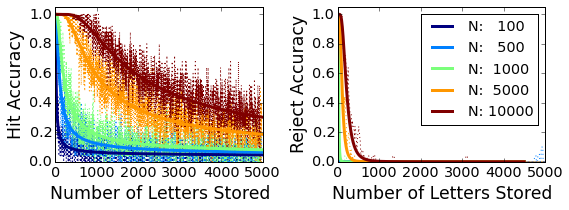

In [154]:

uN = unique(run_N)

figure(figsize=(8,3))
cm=get_cmap('jet', li_mean.shape[1])

subplot(121)
for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_hit_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=1)
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_hit(M, N=N, D=len(random_idx.alphabet)+1, reject_thresh=reject_thresh)
    plot(M, p_correct, color=cm(idxN),lw=3)

#title('Readout of most recent input');
xlabel('Number of Letters Stored');
ylabel('Hit Accuracy')
ylim([0, 1.05])
xlim([0, 5000])

subplot(122)
for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(arange(li_cr_mean.shape[0]) * (1-p_null) / p_null, 
         np.convolve(li_cr_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=1)
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_corr_rej(M, N=N, D=len(random_idx.alphabet)+1, reject_thresh=reject_thresh)
    plot(M*(1-p_null), p_correct, color=cm(idxN), lw=3, label="N: %5i" % test_N[idxN])

legend(loc='upper right');
xlabel('Number of Letters Stored');
ylabel('Reject Accuracy')
ylim([0, 1.05])
xlim([0, 5000])

plt.tight_layout()

savefig('figures/letter_capacity-input_sparsity-rt=' + str(reject_thresh) + '-pn=' + str(p_null) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-input_sparsity-rt=' + str(reject_thresh) + '-pn=' + str(p_null) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

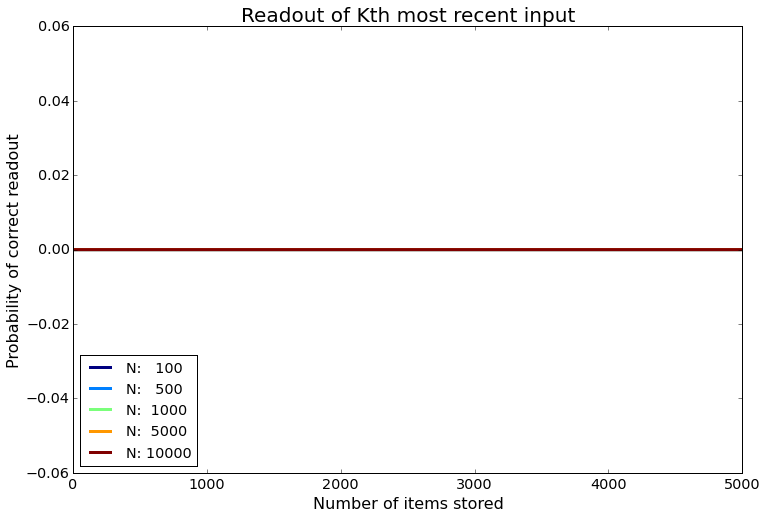

In [116]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])
         
for i in range(iK_mean.shape[1]):
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="N: %5i" % test_N[i])

legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)


In [61]:
D=27
print np.log2(D), D * (-1/D * log2(1/D))

4.75488750216 4.75488750216


In [62]:
hit_li_idxs

array([ 1.,  0.,  1., ...,  0.,  0.,  0.])

In [63]:
amax(lidx_all[0])

27.0

In [64]:
test_N = [100 * 2**(N) for N in range(12)]
test_D = [2**(D) for D in range(16)]

reject_thresh = 0.5

cm=get_cmap('jet', len(test_D))

p_correct_hit = np.zeros((len(test_N), len(test_D), max(test_N)))
for iN,N in enumerate(test_N):
    print N,
    for iD,D in enumerate(test_D):
        p_correct_hit[iN, iD, :N] = p_hit(arange(N)+1, N=N, D=D, reject_thresh=reject_thresh)
        
filename = 'data/p_hit-theory-rj=' + str(reject_thresh) + '-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, p_correct_hit=p_correct_hit, test_N=test_N, test_D=test_D, reject_thresh=reject_thresh)


100 200 400 800 1600 3200 6400 12800 25600

KeyboardInterrupt: 